Generate plots: 10000 units from the dataset (100 000). 

In [1]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
fig_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_abctau\\figs\\'

In [4]:
save_fig = True

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trials (сoncat), abcTau trials

4 different absTau runs:
* abcTau with oneTauOU, min_samples = 50, minAccRate = 0.01
* abctau_run2_dst_gamma: abcTau with oneTauOU_gammaSpikes, min_samples = 50, minAccRate = 0.01
* abcTau with oneTauOU_gammaSpikes, min_samples = 100, minAccRate = 0.003
* abcTau with oneTauOU_gammaSpikes, min_samples = 500, minAccRate = 0.003

For comparison, abctau_run2_dst_gamma is used.

In [5]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_all_long_df: four methods in one wide (ACF, iSTTC, PersonR, iSTTC trails (сoncat))
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat), abcTau')
df_4_methods = pd.read_pickle(results_folder / "summary_tau_all_long_df_all_units.pkl")
df_abctau = pd.read_pickle(results_folder / "summary_tau_all_long_df_all_units_abctau.pkl")

inspect(df_4_methods, "df_4_methods (df_4_methods)")
inspect(df_abctau, "df_abctau (df_abctau)")

# leave only units with all methods (no NaNs and/or r_squared >= 0) - quality thresholds for direct fit
required = {'acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat'}
df_4_methods_clean = (
    df_4_methods.groupby("unit_id")
      .filter(lambda g: (
          len(g) == 4
          and set(g["method"]) == required
          and g.notna().all().all()
          #and (g["fit_r_squared"] >= 0).all()
      ))
)
df_4_methods_clean.reset_index(inplace=True, drop=True)
print(f'len df_4_methods_clean {len(df_4_methods_clean)}, per method {len(df_4_methods_clean)/4}')

ACF, iSTTC, PersonR, iSTTC trails (сoncat), abcTau
len df_4_methods (df_4_methods): 400000
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'lv']
len df_abctau (df_abctau): 7204
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
len df_4_methods_clean 350428, per method 87607.0


In [6]:
df_4_methods_subset = df_4_methods_clean[['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']].copy()
inspect(df_4_methods_subset, "df_4_methods_subset (df_4_methods_subset)")

df_abctau_subset = df_abctau.query('method == "abctau_run2_dst_gamma"').copy()
inspect(df_abctau_subset, "df_abctau_subset (df_abctau_subset)")

df_5_methods = pd.concat([df_4_methods_subset, df_abctau_subset])
df_5_methods.reset_index(inplace=True, drop=True)
inspect(df_5_methods, "df_5_methods (df_5_methods)")

# keep only unit_ids that have all methods present (5 here)
counts = df_5_methods.groupby('unit_id')['method'].nunique()
complete_units = counts[counts == df_5_methods['method'].nunique()].index
df_complete = df_5_methods[df_5_methods['unit_id'].isin(complete_units)].copy()

print(f"Remaining units: {len(complete_units)}")
print(f"Filtered DataFrame shape: {df_complete.shape}")

# get wide version of df
spec_full = {
    "tau_diff_rel_abctau": "abctau_run2_dst_gamma",
    "tau_diff_rel_pearsonr": "pearsonr_trial_avg",
    "tau_diff_rel_sttc_concat": "sttc_trial_concat",
}
tau_full_wide_df = long_to_wide(df_complete, spec_full)
inspect(tau_full_wide_df, "tau_full_wide_df (full)")

len df_4_methods_subset (df_4_methods_subset): 350428
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
len df_abctau_subset (df_abctau_subset): 6105
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
len df_5_methods (df_5_methods): 356533
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
Remaining units: 5386
Filtered DataFrame shape: (26930, 9)
len tau_full_wide_df (full): 5386
['unit_id', 'fr', 'alpha', 'lv', 'tau_ms_true', 'tau_diff_rel_abctau', 'tau_diff_rel_pearsonr', 'tau_diff_rel_sttc_concat']


### Prepare extra dataframes for plotting 

In [7]:
# Dataframe to plot now many spike trains for a method have a REE within certain percentage
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

df = df_complete.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_plot_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_plot_error_df = tau_plot_error_df.reset_index()
tau_plot_error_long_df = tau_plot_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_plot_error_long_df

,method,interval,percentage
0,abctau_run2_dst_gamma,+-100,84.961010
1,acf_full,+-100,97.660602
2,isttc_full,+-100,97.456368
3,pearsonr_trial_avg,+-100,76.420349
4,sttc_trial_concat,+-100,79.093947
5,abctau_run2_dst_gamma,+-75,79.298180
6,acf_full,+-75,95.915336
7,isttc_full,+-75,95.878203
8,pearsonr_trial_avg,+-75,57.352395
9,sttc_trial_concat,+-75,60.267360


In [8]:
# get percentage of units with tau_ms in 100% error range
mask = df_complete['tau_diff_rel'].between(0, 100)
tau_plot_long_0_100perc_df = (
    df_complete
    .groupby('method')
    .agg(
        total       = ('tau_diff_rel', 'size'),
        in_range    = ('tau_diff_rel', lambda x: x.between(0,100).sum())
    )
)
tau_plot_long_0_100perc_df['percent_in_range'] = tau_plot_long_0_100perc_df['in_range'] / tau_plot_long_0_100perc_df['total'] * 100
tau_plot_long_0_100perc_df = tau_plot_long_0_100perc_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_plot_long_0_100perc_df

,total,in_range,percent_in_range
method,,,
abctau_run2_dst_gamma,5386,4576,85.0%
acf_full,5386,5260,97.7%
isttc_full,5386,5249,97.5%
pearsonr_trial_avg,5386,4116,76.4%
sttc_trial_concat,5386,4260,79.1%


### Plots

In [9]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 
color_abctau = '#B4464B'

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat, color_abctau]

color_trails = [color_pearson_trail_avg, color_sttc_trail_concat, color_abctau] # black is when both method failed

In [10]:
def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("abctau_run2_dst_gamma",     color_abctau,     "abctau_run2_dst_gamma"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

def hexbin_pair(
    df, *,
    x1, x2, y,
    c,                            # 1D array/Series with same index as df
    title,
    xlabel1, xlabel2, ylabel,
    xticks2=None, yticks=None,         
    ylim=None,
    gridsize=10,
    cmap="RdBu_r",
    vcenter=0,
    mincnt=1,
    save_path_png=None,           # full path or None
    save_path_svg=None,           # full path or None
):
    """Two-panel hexbin with the SAME symmetric color scale based on 95th pct."""
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    norm = TwoSlopeNorm(vcenter=vcenter)

    hb0 = axes[0].hexbin(
        x=df[x1], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )
    hb1 = axes[1].hexbin(
        x=df[x2], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )

    # Symmetric colorbar limits from both panels (95th percentile of |values|)
    arr = np.hstack([hb0.get_array(), hb1.get_array()])
    bar_lim = np.percentile(np.abs(arr), 95)
    hb0.set_clim(-bar_lim, bar_lim)
    hb1.set_clim(-bar_lim, bar_lim)

    fig.colorbar(hb0, ax=axes[0], shrink=1)
    fig.colorbar(hb1, ax=axes[1], shrink=1)

    axes[0].set_xlabel(xlabel1)
    axes[1].set_xlabel(xlabel2)
    if xticks2 is not None:
        axes[1].set_xticks(xticks2)

    fig.suptitle(title, y=1.05)

    for ax in axes.flat:
        sns.despine(ax=ax)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if yticks is not None:
            ax.set_yticks(yticks)

    if save_path_png:
        fig.savefig(save_path_png, bbox_inches="tight", dpi=300)
    if save_path_svg:
        fig.savefig(save_path_svg, bbox_inches="tight")

    return fig, axes

In [ ]:
tau_full_wide_df

C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


(<Figure size 800x250 with 4 Axes>,
 array([<Axes: xlabel='Firing rate (Hz)', ylabel='Excitation strength (a.u.)'>,
        <Axes: xlabel='Intrinsic timescale (ms)', ylabel='Excitation strength (a.u.)'>],
       dtype=object))

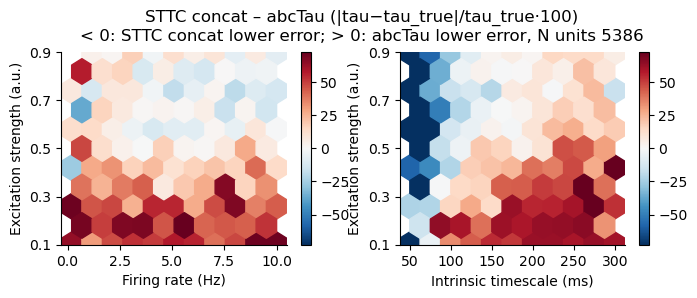

In [11]:
c1 = tau_full_wide_df["tau_diff_rel_sttc_concat"] - \
     tau_full_wide_df["tau_diff_rel_abctau"]

hexbin_pair(
    tau_full_wide_df,
    x1="fr", x2="tau_ms_true", y="alpha", c=c1,
    title=f'STTC concat – abcTau (|tau−tau_true|/tau_true·100)\n< 0: STTC concat lower error; > 0: abcTau lower error, N units {len(tau_full_wide_df)}',
    xlabel1="Firing rate (Hz)", xlabel2="Intrinsic timescale (ms)", ylabel = "Excitation strength (a.u.)",
    xticks2=np.linspace(50, 300, 6), yticks=np.linspace(0.1, 0.9, 5),
    ylim=[0.1, 0.9],
    save_path_png=fig_folder + "taus_dataset_3_var_rel_diff_trials_abctau_concat.png" if save_fig else None,
    save_path_svg=fig_folder + "taus_dataset_3_var_rel_diff_trials_abctau_concat.svg" if save_fig else None,
)

C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\joypy\joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


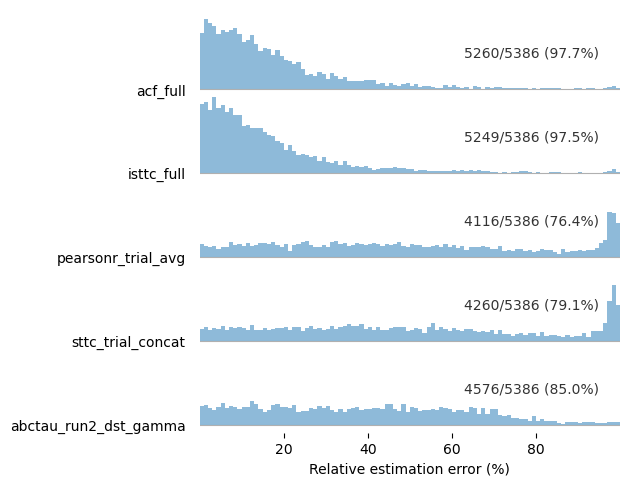

In [12]:
method_order = [
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_concat',
    'abctau_run2_dst_gamma'
]

df_complete["method"] = pd.Categorical(
    df_complete["method"],
    categories=method_order,
    ordered=True
)

fig, axes = joypy.joyplot(data=df_complete.query('tau_diff_rel >= 0 and tau_diff_rel <= 100'),
    by='method',
    column='tau_diff_rel',
    #range_style='own',
    ylim = 'max',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0,100]
)

#axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Relative estimation error (%)')
#fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)

for ax, method in zip(axes, method_order):
    tot    = tau_plot_long_0_100perc_df.at[method, 'total']
    inn    = tau_plot_long_0_100perc_df.at[method, 'in_range']
    pct    = tau_plot_long_0_100perc_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_one_trial_impl_rel_error_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_one_trial_impl_rel_error_hist.svg' , bbox_inches='tight')

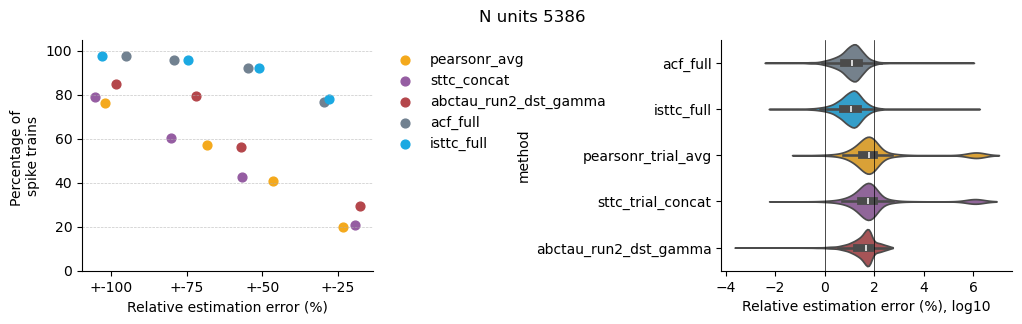

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

plot_one_threshold_jittered_lines(axes[0],
    tau_plot_error_long_df,
    jitter=0.3, seed=42)
axes[0].set_ylabel('Percentage of \nspike trains')
axes[0].set_xlabel('Relative estimation error (%)')
axes[0].set_ylim([0, 105])
axes[0].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

df_complete['tau_diff_rel_log10'] = np.log10(df_complete['tau_diff_rel'])
method_order = ['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_run2_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=df_complete , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

fig.suptitle(f'N units {len(tau_full_wide_df)}')

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_taus_rel_error_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_taus_rel_error_one_trials_impl.svg' , bbox_inches='tight')

### Inclusion

In [ ]:
df_4_methods

In [14]:
df_4_methods_10000 = df_4_methods.query('unit_id < 10000').copy()
inspect(df_4_methods_10000, "df_4_methods_10000 (df_4_methods_10000)")

len df_4_methods_10000 (df_4_methods_10000): 40000
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'lv']


In [18]:
# temp for abcTau while computation is running
intervals = [
    (0, 4000),
    (4000, 5329),
    (6000, 6858),
    (8000, 8329)
]
numbers = []
for start, end in intervals:
    numbers.extend(range(start, end + 1))
    
missing_mask = ~pd.Series(numbers).isin(df_abctau_subset["unit_id"])
missing_numbers = pd.Series(numbers)[missing_mask].tolist()
len(missing_numbers)

414

In [22]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = df_4_methods_10000.groupby('method').apply(compute_exclusion).reset_index()

# temp for abcTau while computation is running
exclusion_df.loc[len(exclusion_df)] = ['abcTau', len(missing_numbers), np.nan, len(missing_numbers), 
                                       len(missing_numbers) / len(numbers) * 100, np.nan, len(missing_numbers) / len(numbers) * 100]

diff_trial_methods = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'tau_nans'] - \
                     exclusion_df.set_index('method').loc['abcTau', 'tau_nans']
diff_trial_methods_perc = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'percent_tau_nans'] - \
                     exclusion_df.set_index('method').loc['abcTau', 'percent_tau_nans']
print(f'diff_trial_methods {diff_trial_methods}, diff_trial_methods_perc {diff_trial_methods_perc}')

exclusion_df


diff_trial_methods 833.0, diff_trial_methods_perc 6.120306748466259


C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\3515270798.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = df_4_methods_10000.groupby('method').apply(compute_exclusion).reset_index()


,method,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,acf_full,0.0,25.0,25.0,0.000000,0.25,0.250000
1,isttc_full,0.0,22.0,22.0,0.000000,0.22,0.220000
2,pearsonr_trial_avg,1247.0,389.0,1636.0,12.470000,3.89,16.360000
3,sttc_trial_concat,0.0,618.0,618.0,0.000000,6.18,6.180000
4,abcTau,414.0,NaN,414.0,6.349693,NaN,6.349693


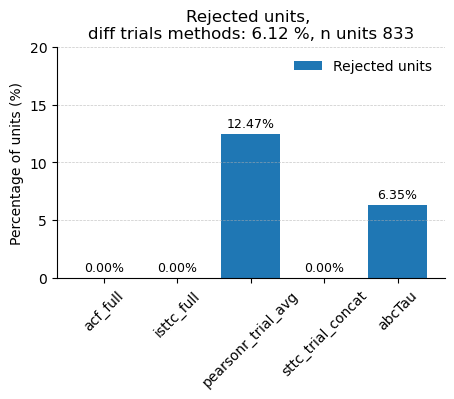

In [24]:
methods = exclusion_df['method']
x = np.arange(len(methods))

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, exclusion_df['percent_tau_nans'], label='Rejected units')
#axes.bar(x, exclusion_df['percent_fit_r_squared_neg'], bottom=exclusion_df['percent_tau_nans'], label='Negative R-squared')
axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'Rejected units, \ndiff trials methods: {diff_trial_methods_perc:.2f} %, n units {int(diff_trial_methods)}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_yticks([0,5,10,15,20])

total = exclusion_df['percent_tau_nans']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_plot.svg' , bbox_inches='tight')

In [25]:
df_missing = pd.DataFrame({
    "unit_id": missing_numbers,
    "method": "abctau_run2_dst_gamma"
})

df_missing.head()

,unit_id,method
0,33,abctau_run2_dst_gamma
1,52,abctau_run2_dst_gamma
2,61,abctau_run2_dst_gamma
3,75,abctau_run2_dst_gamma
4,135,abctau_run2_dst_gamma


In [26]:
df_missing_abctau = df_missing.merge(df_4_methods_10000.query('method == "sttc_trial_concat"')[['unit_id', 'fr', 'alpha', 'tau_ms_true']].copy(), 
                                     on='unit_id', how='left')
df_missing_abctau

,unit_id,method,fr,alpha,tau_ms_true
0,33,abctau_run2_dst_gamma,3.710892,0.461784,226.166995
1,52,abctau_run2_dst_gamma,7.871375,0.716825,139.967937
2,61,abctau_run2_dst_gamma,4.716251,0.852041,112.675495
3,75,abctau_run2_dst_gamma,2.821025,0.481244,289.479758
4,135,abctau_run2_dst_gamma,0.237811,0.534132,229.181129
...,...,...,...,...,...
409,8285,abctau_run2_dst_gamma,1.685067,0.227615,195.048243
410,8299,abctau_run2_dst_gamma,3.451517,0.335242,165.617586
411,8300,abctau_run2_dst_gamma,7.050876,0.381918,178.069479
412,8302,abctau_run2_dst_gamma,2.199550,0.351788,178.497507


In [27]:
#nans_neg_r2_df = df_4_methods_10000.query('tau.isna() or fit_r_squared < 0')[['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true']].copy()
nans_neg_r2_df = df_4_methods_10000.query('tau.isna()')[['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true']].copy()
print(nans_neg_r2_df.keys())

nans_neg_r2_df_trials = nans_neg_r2_df[nans_neg_r2_df['method'].isin(['pearsonr_trial_avg', 'sttc_trial_concat'])]
nans_neg_r2_df_trials = pd.concat([nans_neg_r2_df_trials, df_missing_abctau])

nans_neg_r2_df_trials.reset_index(inplace=True, drop=True)
method_counts = nans_neg_r2_df_trials.groupby('unit_id')['method'].nunique()
both_methods = method_counts[method_counts == 3].index

# Count
num_both = len(both_methods)
print(f"Number of units with both methods: {num_both}")

Index(['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true'], dtype='object')
Number of units with both methods: 0


In [ ]:
nans_neg_r2_df_trials.groupby(by='method').count()

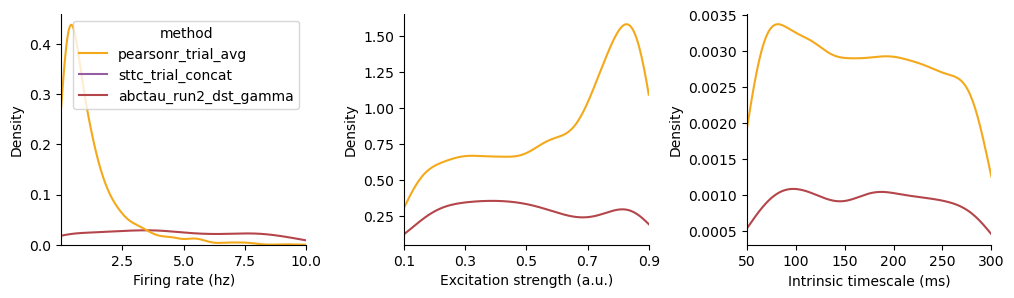

In [28]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(
    data=nans_neg_r2_df_trials, 
    x='fr', 
    hue='method', 
    hue_order=['pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_run2_dst_gamma'],    
    clip=(0, 10),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=True,
    ax=axes[0]
)

sns.kdeplot(
    data=nans_neg_r2_df_trials, 
    x='alpha', 
    hue='method', 
    hue_order=['pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_run2_dst_gamma'],    
    clip=(0.1, 0.9),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=False,
    ax=axes[1]
)

sns.kdeplot(
    data=nans_neg_r2_df_trials, 
    x='tau_ms_true', 
    hue='method', 
    hue_order=['pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_run2_dst_gamma'],    
    clip=(50, 300),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=False,
    ax=axes[2]
)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Excitation strength (a.u.)')
axes[2].set_xlabel('Intrinsic timescale (ms)')

axes[0].set_xticks(np.linspace(0, 10, 5))
axes[2].set_xticks(np.linspace(50, 300, 6))
axes[1].set_xticks(np.linspace(0.1, 0.9, 5))

axes[0].set_xlim([0.01, 10])
axes[1].set_xlim([0.1, 0.9])
axes[2].set_xlim([50, 300])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.svg' , bbox_inches='tight')

### Compare abcTau runs

In [ ]:
df_abctau

C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1583460564.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1583460564.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(labels_with_n)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1583460564.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels_with_n)


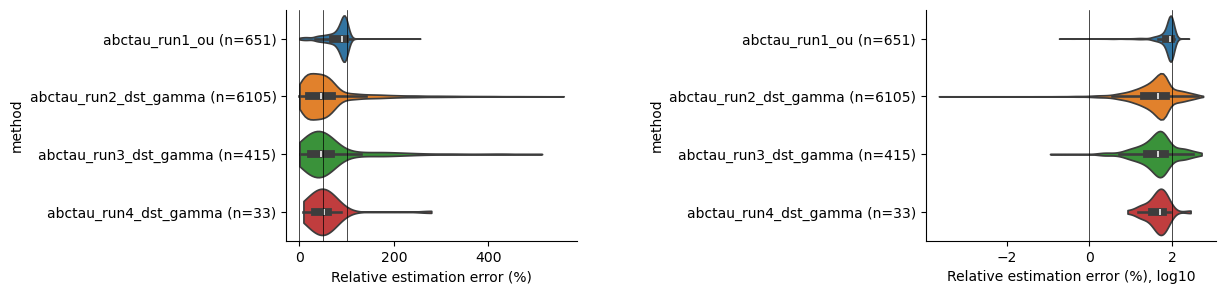

In [30]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau , cut=0, ax=axes[0])
axes[0].axvline(x=0, lw=0.5, c='k')
axes[0].axvline(x=50, lw=0.5, c='k')
axes[0].axvline(x=100, lw=0.5, c='k')
axes[0].set_xlabel('Relative estimation error (%)')

df_abctau['tau_diff_rel_log10'] = np.log10(df_abctau['tau_diff_rel'])
method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

# counts per method (unique units)
counts = (
    df_abctau.groupby('method')['unit_id']
    .nunique()
    .reindex(method_order)       
    .fillna(0).astype(int)
)
labels_with_n = [f"{m} (n={counts.get(m, 0)})" for m in method_order]
axes[0].set_yticklabels(labels_with_n)
axes[1].set_yticklabels(labels_with_n)

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl.svg' , bbox_inches='tight')

Remaining units: 33
Filtered DataFrame shape: (132, 10)


C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1705366589.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1705366589.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(labels_with_n)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1705366589.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels_with_n)


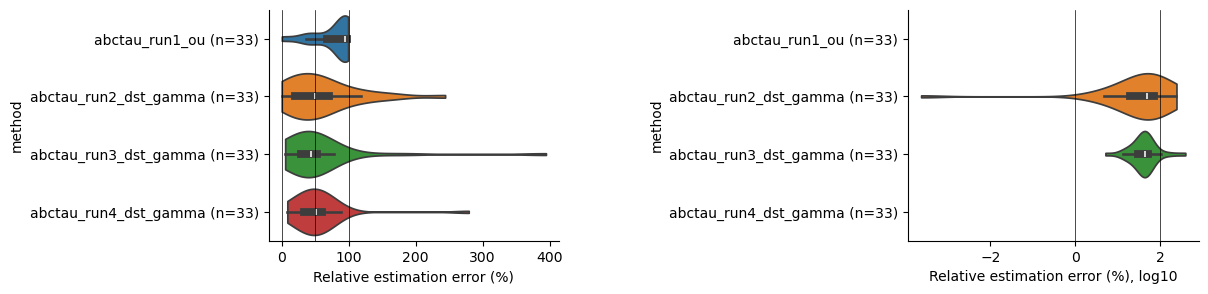

In [37]:
# keep only unit_ids that have all methods present 
counts = df_abctau.groupby('unit_id')['method'].nunique()
complete_units = counts[counts == df_abctau['method'].nunique()].index
df_abctau_complete = df_abctau[df_abctau['unit_id'].isin(complete_units)].copy()
print(f"Remaining units: {len(complete_units)}")
print(f"Filtered DataFrame shape: {df_abctau_complete.shape}")


fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[0])
axes[0].axvline(x=0, lw=0.5, c='k')
axes[0].axvline(x=50, lw=0.5, c='k')
axes[0].axvline(x=100, lw=0.5, c='k')
axes[0].set_xlabel('Relative estimation error (%)')

df_abctau['tau_diff_rel_log10'] = np.log10(df_abctau['tau_diff_rel'])
method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

# counts per method (unique units)
counts = (
    df_abctau_complete.groupby('method')['unit_id']
    .nunique()
    .reindex(method_order)       
    .fillna(0).astype(int)
)
labels_with_n = [f"{m} (n={counts.get(m, 0)})" for m in method_order]
axes[0].set_yticklabels(labels_with_n)
axes[1].set_yticklabels(labels_with_n)

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units_4runs.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units.svg' , bbox_inches='tight')

In [33]:
df_abctau

,unit_id,tau_ms,method,fr,alpha,tau_ms_true,lv,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10
0,1303,282.787084,abctau_run1_ou,2.581649,0.858982,172.572553,1.327349,110.214531,63.865620,1.805267
1,0,95.733949,abctau_run1_ou,7.741821,0.851099,150.923515,1.307775,55.189566,36.567904,1.563100
2,1,93.162482,abctau_run1_ou,4.394396,0.858098,147.947233,1.345006,54.784751,37.029926,1.568553
3,2,3.776298,abctau_run1_ou,8.587393,0.528805,267.002290,1.068416,263.225991,98.585668,1.993814
4,3,6.976921,abctau_run1_ou,6.976707,0.300692,194.403797,1.055631,187.426875,96.411119,1.984127
...,...,...,...,...,...,...,...,...,...,...
7199,28,62.608460,abctau_run4_dst_gamma,1.551352,0.869480,290.790300,1.360630,228.181840,78.469550,1.894701
7200,29,73.631517,abctau_run4_dst_gamma,6.833659,0.195178,180.314131,1.027506,106.682614,59.164866,1.772064
7201,30,94.258987,abctau_run4_dst_gamma,7.450174,0.412868,150.464001,1.123272,56.205014,37.354459,1.572342
7202,31,200.085329,abctau_run4_dst_gamma,9.675422,0.197857,150.122967,1.023090,49.962362,33.280958,1.522196


Remaining units: 415
Filtered DataFrame shape: (830, 10)


C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1809074463.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1809074463.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(labels_with_n)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_6452\1809074463.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels_with_n)


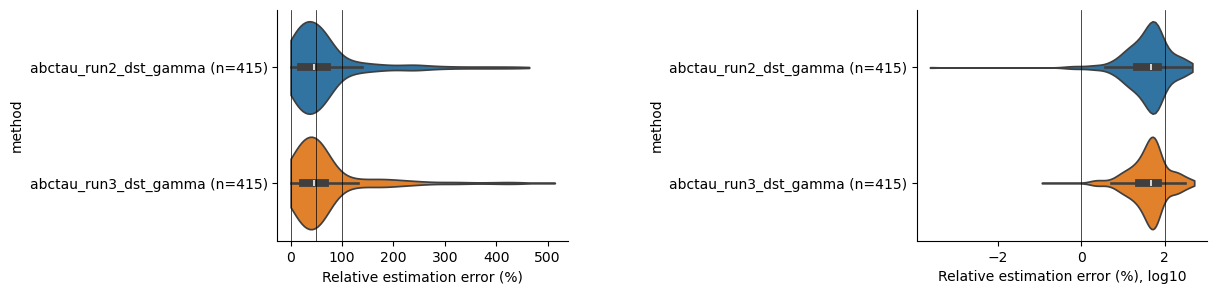

In [36]:
# keep only unit_ids that have all methods present 
df_abctau_subset = df_abctau.query('method == "abctau_run2_dst_gamma" or method == "abctau_run3_dst_gamma"').copy()
counts = df_abctau_subset.query('method == "abctau_run2_dst_gamma" or method == "abctau_run3_dst_gamma" ').groupby('unit_id')['method'].nunique()
complete_units = counts[counts == df_abctau_subset['method'].nunique()].index
df_abctau_complete = df_abctau_subset[df_abctau_subset['unit_id'].isin(complete_units)].copy()
print(f"Remaining units: {len(complete_units)}")
print(f"Filtered DataFrame shape: {df_abctau_complete.shape}")


fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

method_order = ['abctau_run2_dst_gamma', 'abctau_run3_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[0])
axes[0].axvline(x=0, lw=0.5, c='k')
axes[0].axvline(x=50, lw=0.5, c='k')
axes[0].axvline(x=100, lw=0.5, c='k')
axes[0].set_xlabel('Relative estimation error (%)')

df_abctau['tau_diff_rel_log10'] = np.log10(df_abctau_subset['tau_diff_rel'])
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

# counts per method (unique units)
counts = (
    df_abctau_complete.groupby('method')['unit_id']
    .nunique()
    .reindex(method_order)       
    .fillna(0).astype(int)
)
labels_with_n = [f"{m} (n={counts.get(m, 0)})" for m in method_order]
axes[0].set_yticklabels(labels_with_n)
axes[1].set_yticklabels(labels_with_n)

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units_2runs.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units.svg' , bbox_inches='tight')